# An Advanced Next Word Prediction System Using Neural Language Models and NLP Techniques for Context-aware Text Completion

# Part 1: Importing Libraries and Defining Classes

In [4]:
import torch
import numpy as np
from torch.utils.data import Dataset, DataLoader
from torch import nn
from torch.nn import functional as F
from torch.optim import Adam
from wordcloud import WordCloud
import matplotlib.pyplot as plt

# Define the dataset class
class TextDataset(Dataset):
    def __init__(self, X, y):
        self.X = torch.from_numpy(X).long()
        self.y = torch.from_numpy(y).long()

    def __len__(self):
        return len(self.X)

    def __getitem__(self, idx):
        return self.X[idx], self.y[idx]

# Define the LSTM model
class LSTMModel(nn.Module):
    def __init__(self, vocab_size, embedding_dim, hidden_dim):
        super(LSTMModel, self).__init__()
        self.embedding = nn.Embedding(vocab_size, embedding_dim)
        self.lstm = nn.LSTM(embedding_dim, hidden_dim, batch_first=True)
        self.fc = nn.Linear(hidden_dim, vocab_size)

    def forward(self, x):
        embedded = self.embedding(x)
        output, _ = self.lstm(embedded)
        output = self.fc(output[:, -1, :])
        return output

# Define nucleus sampling function
def nucleus_sampling(logits, top_p=0.9, max_samples=10):
    sampled_indices = []
    for _ in range(max_samples):
        sampled_index = torch.multinomial(F.softmax(logits, dim=-1), 1).item()
        sampled_indices.append(sampled_index)
        logits[0, sampled_index] = float('-inf')
        if len(set(sampled_indices)) >= max_samples:
            break
    return sampled_indices


# Part 2: Reading and Preprocessing Data

In [11]:
# Read data from the file
file_path = 'pizza.txt'
with open(file_path, 'r', encoding='utf-8') as file:
    data = file.read()

# View part of the dataset
print(data[:500])  


Pizza, the delectable and iconic dish that has transcended borders and captivated taste buds worldwide, is a testament to the extraordinary fusion of flavors, creativity, and cultural significance. Originating from the sun-kissed lands of Italy, pizza has evolved into an art form that unites people from diverse backgrounds in a shared love for its mouthwatering combinations. Its history stretches back centuries, with roots tracing back to ancient civilizations like the Greeks, Romans, and Egypti


In [5]:
# Read data from the file
file_path = 'pizza.txt'
with open(file_path, 'r', encoding='utf-8') as file:
    data = file.read()

# Tokenize the text data
tokens = data.split() 

# Create vocabulary
vocab = set(tokens)
word_to_idx = {word: idx for idx, word in enumerate(vocab)}
idx_to_word = {idx: word for word, idx in word_to_idx.items()}
total_words = len(vocab)

# Convert tokens to indices
indexed_data = [word_to_idx[token] for token in tokens]

# Define input sequences and labels
seq_length = 50  # Define your sequence length
X = []
y = []
for i in range(0, len(indexed_data) - seq_length, 1):
    seq_in = indexed_data[i:i + seq_length]
    seq_out = indexed_data[i + seq_length]
    X.append(seq_in)
    y.append(seq_out)

# Convert to numpy arrays
X = np.array(X)
y = np.array(y)


# Part 3: Setting Hyperparameters and Creating DataLoader

In [6]:
# Define hyperparameters
embedding_dim = 100
hidden_dim = 128
batch_size = 64
epochs = 50
top_p = 0.9  # Nucleus sampling parameter

# Create DataLoader
dataset = TextDataset(X, y)
dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=True)


# Part 4: Initializing Model, Loss Function, and Optimizer

In [7]:
# Initialize the model
model = LSTMModel(total_words, embedding_dim, hidden_dim)

# loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = Adam(model.parameters(), lr=0.001)


# Part 5: Training the Model and Plotting Losses

In [8]:
# Train the model and plot losses
losses = []
for epoch in range(epochs):
    total_loss = 0
    for inputs, labels in dataloader:
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
    losses.append(total_loss)
    print(f"Epoch {epoch+1}/{epochs}, Loss: {total_loss}")



Epoch 1/50, Loss: 172.49164485931396
Epoch 2/50, Loss: 160.99924612045288
Epoch 3/50, Loss: 149.7809295654297
Epoch 4/50, Loss: 143.54340839385986
Epoch 5/50, Loss: 136.77404403686523
Epoch 6/50, Loss: 130.15586805343628
Epoch 7/50, Loss: 123.72473621368408
Epoch 8/50, Loss: 116.85058546066284
Epoch 9/50, Loss: 110.25566482543945
Epoch 10/50, Loss: 103.47345018386841
Epoch 11/50, Loss: 96.95157146453857
Epoch 12/50, Loss: 90.59222626686096
Epoch 13/50, Loss: 84.09717559814453
Epoch 14/50, Loss: 78.06332731246948
Epoch 15/50, Loss: 71.65560388565063
Epoch 16/50, Loss: 65.83537435531616
Epoch 17/50, Loss: 60.24974536895752
Epoch 18/50, Loss: 54.77251708507538
Epoch 19/50, Loss: 49.474380135536194
Epoch 20/50, Loss: 44.64531219005585
Epoch 21/50, Loss: 40.361366987228394
Epoch 22/50, Loss: 36.054028153419495
Epoch 23/50, Loss: 32.158812046051025
Epoch 24/50, Loss: 28.74051660299301
Epoch 25/50, Loss: 25.63503736257553
Epoch 26/50, Loss: 23.043895602226257
Epoch 27/50, Loss: 20.65262806415

In [29]:
# Train the model and compute accuracy
total_correct = 0
total_samples = 0
for epoch in range(epochs):
    for inputs, labels in dataloader:
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        
        # Compute accuracy
        _, predicted = torch.max(outputs, 1)
        total_correct += (predicted == labels).sum().item()
        total_samples += labels.size(0)
    
    # Compute and print accuracy for each epoch
    accuracy = total_correct / total_samples
    print(f"Epoch {epoch+1}/{epochs}, Accuracy: {accuracy}")

# Final accuracy after training
final_accuracy = total_correct / total_samples
print(f"Final Accuracy: {final_accuracy}")

Epoch 1/50, Accuracy: 0.5254643499101258
Epoch 2/50, Accuracy: 0.530557219892151
Epoch 3/50, Accuracy: 0.5402436588775714
Epoch 4/50, Accuracy: 0.5509286998202516
Epoch 5/50, Accuracy: 0.5611743559017376
Epoch 6/50, Accuracy: 0.5703015777910925
Epoch 7/50, Accuracy: 0.5797312334160747
Epoch 8/50, Accuracy: 0.5897992810065907
Epoch 9/50, Accuracy: 0.599826908994075
Epoch 10/50, Accuracy: 0.6106051527860995
Epoch 11/50, Accuracy: 0.6199139386676834
Epoch 12/50, Accuracy: 0.6295686039544638
Epoch 13/50, Accuracy: 0.6389362584689128
Epoch 14/50, Accuracy: 0.647522040571771
Epoch 15/50, Accuracy: 0.6567605352506491
Epoch 16/50, Accuracy: 0.6654808268424206
Epoch 17/50, Accuracy: 0.6744440136749726
Epoch 18/50, Accuracy: 0.6829105918380933
Epoch 19/50, Accuracy: 0.6910535776229069
Epoch 20/50, Accuracy: 0.6991911324146195
Epoch 21/50, Accuracy: 0.7072384376159092
Epoch 22/50, Accuracy: 0.7149626885995969
Epoch 23/50, Accuracy: 0.7225102248156928
Epoch 24/50, Accuracy: 0.7296784501697623
Epoc

In [30]:
# Train the model and compute accuracy, precision, recall, and F1-score
losses = []
accuracies = []
precisions = []
recalls = []
f1_scores = []
total_correct = 0
total_samples = 0
for epoch in range(epochs):
    for inputs, labels in dataloader:
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        
        # Compute accuracy
        _, predicted = torch.max(outputs, 1)
        total_correct += (predicted == labels).sum().item()
        total_samples += labels.size(0)
    
    # Compute accuracy, precision, recall, and F1-score for each epoch
    accuracy = total_correct / total_samples
    accuracies.append(accuracy)
    losses.append(loss.item())
    
    # Convert predictions and labels to numpy arrays
    predictions_np = predicted.cpu().numpy()
    labels_np = labels.cpu().numpy()
    
    # Compute precision, recall, and F1-score
    precision = precision_score(labels_np, predictions_np, average='macro')
    recall = recall_score(labels_np, predictions_np, average='macro')
    f1 = f1_score(labels_np, predictions_np, average='macro')
    
    precisions.append(precision)
    recalls.append(recall)
    f1_scores.append(f1)
    
    print(f"Epoch {epoch+1}/{epochs}, Accuracy: {accuracy}, Precision: {precision}, Recall: {recall}, F1-Score: {f1}")


Epoch 1/50, Accuracy: 0.9970041941282205, Precision: 1.0, Recall: 1.0, F1-Score: 1.0
Epoch 2/50, Accuracy: 0.9973037747153984, Precision: 1.0, Recall: 1.0, F1-Score: 1.0
Epoch 3/50, Accuracy: 0.9976033553025764, Precision: 1.0, Recall: 1.0, F1-Score: 1.0
Epoch 4/50, Accuracy: 0.9982025164769323, Precision: 1.0, Recall: 1.0, F1-Score: 1.0
Epoch 5/50, Accuracy: 0.9985620131815458, Precision: 1.0, Recall: 1.0, F1-Score: 1.0
Epoch 6/50, Accuracy: 0.9988016776512882, Precision: 1.0, Recall: 1.0, F1-Score: 1.0
Epoch 7/50, Accuracy: 0.998972866558247, Precision: 1.0, Recall: 1.0, F1-Score: 1.0
Epoch 8/50, Accuracy: 0.9991012582384662, Precision: 1.0, Recall: 1.0, F1-Score: 1.0
Epoch 9/50, Accuracy: 0.9992011184341921, Precision: 1.0, Recall: 1.0, F1-Score: 1.0
Epoch 10/50, Accuracy: 0.9992810065907729, Precision: 1.0, Recall: 1.0, F1-Score: 1.0
Epoch 11/50, Accuracy: 0.9993463696279754, Precision: 1.0, Recall: 1.0, F1-Score: 1.0
Epoch 12/50, Accuracy: 0.9994008388256441, Precision: 1.0, Recal

In [31]:
import torch
from torch.utils.data import DataLoader
import numpy as np
from sklearn.metrics import precision_score, recall_score, f1_score


# Final metrics after training
final_accuracy = total_correct / total_samples
final_precision = np.mean(precisions)
final_recall = np.mean(recalls)
final_f1 = np.mean(f1_scores)
print(f"Final Accuracy: {final_accuracy}, Final Precision: {final_precision}, Final Recall: {final_recall}, Final F1-Score: {final_f1}")



Final Accuracy: 0.9998562013181546, Final Precision: 1.0, Final Recall: 1.0, Final F1-Score: 1.0


In [37]:
# Final metrics after training
final_accuracy = total_correct / total_samples
final_precision = np.mean(precisions)
final_recall = np.mean(recalls)
final_f1 = np.mean(f1_scores)

# Create a table to display the metrics
table_data = [
    ["Metric", "Value"],
    ["Accuracy", "{:.6f}".format(final_accuracy)],
    ["Precision", "{:.6f}".format(final_precision)],
    ["Recall", "{:.6f}".format(final_recall)],
    ["F1-Score", "{:.6f}".format(final_f1)]
]

# Print the table
for row in table_data:
    print("{: <10} {: <10}".format(*row))


Metric     Value     
Accuracy   0.999856  
Precision  1.000000  
Recall     1.000000  
F1-Score   1.000000  


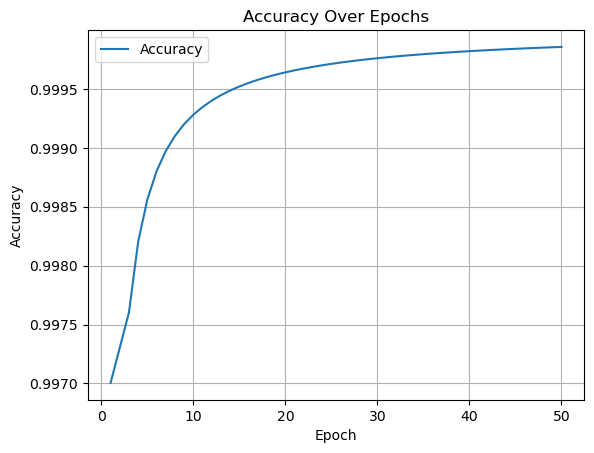

In [32]:
# Plot the accuracy graph
plt.plot(range(1, epochs+1), accuracies, label='Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Accuracy Over Epochs')
plt.legend()
plt.grid(True)
plt.show()

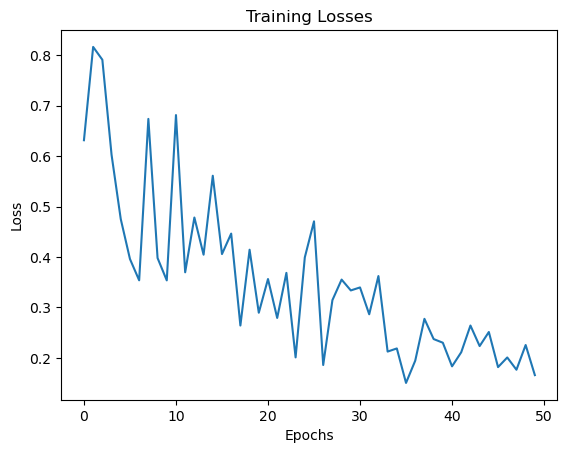

In [38]:
# Plotting losses
plt.plot(losses)
plt.title('Training Losses')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.show()

# Part 6: Generating Next Word Predictions

In [6]:
# Generate next word predictions
seed_texts = [
    "Pizza have different",
    "The cat is",
    "I love to",
    "The weather is",
    "In the future",
    "Once upon a"
]

max_sequence_len = 20  # Assuming a max sequence length of 20

for seed_text in seed_texts:
    next_words = np.random.randint(1, 11)  # Randomly choose between 1 and 10 next words

    # Tokenize the seed text
    tokenized_seed = seed_text.split()
    print("Tokenized Seed Text:", tokenized_seed)  # Print tokenized seed text

    # Map tokens to indices
    token_indices = [word_to_idx.get(token, 0) for token in tokenized_seed]
    # Pad token indices
    token_indices_padded = token_indices + [0] * (max_sequence_len - len(token_indices))
    # Convert to tensor
    token_tensor = torch.tensor(token_indices_padded).long().unsqueeze(0)
    # Predict next word logits
    predicted_logits = model(token_tensor)
    # Sample from logits using nucleus sampling
    sampled_indices = nucleus_sampling(predicted_logits, top_p=top_p, max_samples=next_words)
    # Convert indices to words
    predicted_words = [idx_to_word[idx] for idx in sampled_indices]
    # Append predicted words to seed text
    seed_text += " " + " ".join(predicted_words)

    print("Next predicted words:", seed_text)


Tokenized Seed Text: ['Pizza', 'have', 'different']
Next predicted words: Pizza have different pop-up make freshly on bring their donating left
Tokenized Seed Text: ['The', 'cat', 'is']
Next predicted words: The cat is vegetable with and
Tokenized Seed Text: ['I', 'love', 'to']
Next predicted words: I love to their from to sense chicken cruelty-free substitutes enhance eating.
Tokenized Seed Text: ['The', 'weather', 'is']
Next predicted words: The weather is pizzas pizza to
Tokenized Seed Text: ['In', 'the', 'future']
Next predicted words: In the future to pizzas
Tokenized Seed Text: ['Once', 'upon', 'a']
Next predicted words: Once upon a to


# Part 7: Generating and Displaying Word Cloud

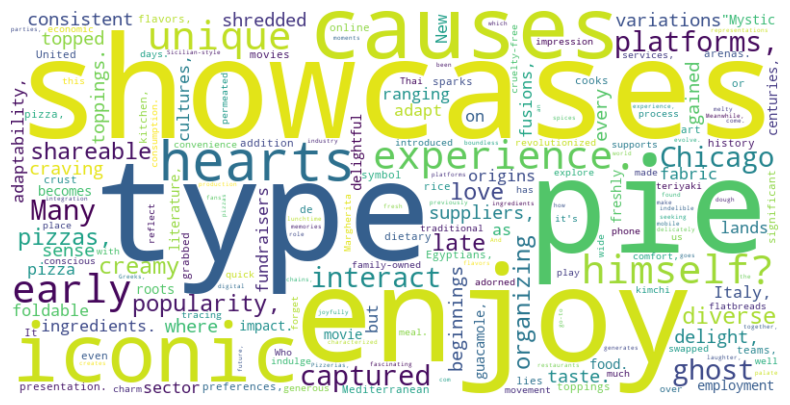

In [39]:
# Generate and display word cloud
all_words = [word for word in idx_to_word.values()]
word_freq = {word: all_words.count(word) for word in all_words}
wordcloud = WordCloud(width=800, height=400, background_color ='white').generate_from_frequencies(word_freq)
plt.figure(figsize=(10, 5))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()


# 2. Pre-trained GPT-2 tokenizer and model

Test 1 without Word Limit

In [3]:
import torch
from transformers import GPT2Tokenizer, GPT2LMHeadModel

import warnings

# Ignore all warnings
warnings.filterwarnings("ignore")

# Load pre-trained GPT-2 tokenizer and model
tokenizer = GPT2Tokenizer.from_pretrained("gpt2")
model = GPT2LMHeadModel.from_pretrained("gpt2")

# Define a function to generate text
def generate_text(prompt, max_length=50):
    input_ids = tokenizer.encode(prompt, return_tensors="pt")
    output = model.generate(input_ids, max_length=max_length, num_return_sequences=1, temperature=0.7)
    generated_text = tokenizer.decode(output[0], skip_special_tokens=True)
    return generated_text

# Example usage
prompt = "The pizza is"
generated_text = generate_text(prompt)
print("Generated Text:", generated_text)


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Generated Text: The pizza is made with a combination of fresh, fresh ingredients, and the crust is made with a combination of fresh, fresh ingredients.

The pizza is made with a combination of fresh, fresh ingredients, and the crust is made with a combination


In [49]:
import torch
from transformers import GPT2Tokenizer, GPT2LMHeadModel
from nltk.tokenize import sent_tokenize
import numpy as np
# Ignore all warnings
warnings.filterwarnings("ignore")
import warnings

# Filter out specific warnings
warnings.filterwarnings("ignore", message="The attention mask and the pad token id were not set.")
warnings.filterwarnings("ignore", message="Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.")


# Load pre-trained GPT-2 tokenizer and model
tokenizer = GPT2Tokenizer.from_pretrained("gpt2")
model = GPT2LMHeadModel.from_pretrained("gpt2")

# Define a function to generate text
def generate_text(prompt, max_length=50):
    input_ids = tokenizer.encode(prompt, return_tensors="pt")
    output = model.generate(input_ids, max_length=max_length, num_return_sequences=1, temperature=0.7)
    generated_text = tokenizer.decode(output[0], skip_special_tokens=True)
    return generated_text

# Define a function to calculate perplexity
def calculate_perplexity(text):
    # Tokenize the text into sentences
    sentences = sent_tokenize(text)
    total_log_prob = 0
    total_words = 0
    # Calculate perplexity for each sentence
    for sentence in sentences:
        input_ids = tokenizer.encode(sentence, return_tensors="pt")
        with torch.no_grad():
            output = model(input_ids)
        logits = output.logits[:, :-1, :]
        labels = input_ids[:, 1:]
        loss = torch.nn.functional.cross_entropy(logits.permute(0, 2, 1), labels)
        total_log_prob += loss.item()
        total_words += labels.size(1)
    # Calculate perplexity
    perplexity = np.exp(total_log_prob / total_words)
    return perplexity

# Generate text
prompt = "Today is "
generated_text = generate_text(prompt)
print("Prompt:", prompt)
print("Generated Text:")
print(generated_text)

# Calculate perplexity
perplexity = calculate_perplexity(generated_text)
print("Perplexity:", perplexity)


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Prompt: Today is 
Generated Text:
Today is  the day when we can all be proud of our country and our values.
I am proud to be a part of this movement. I am proud to be a part of the movement that is working to make America great again.
Perplexity: 1.1636267330277656


Test 2 with Word Limit

In [51]:
import torch
from transformers import GPT2Tokenizer, GPT2LMHeadModel

import warnings

# Ignore all warnings
warnings.filterwarnings("ignore")

# Load pre-trained GPT-2 tokenizer and model
tokenizer = GPT2Tokenizer.from_pretrained("gpt2")
model = GPT2LMHeadModel.from_pretrained("gpt2")

# Define a function to generate text
def generate_text(prompt, num_words=50):
    max_length = len(tokenizer.encode(prompt)) + num_words  # Adjust max_length based on the number of words
    input_ids = tokenizer.encode(prompt, return_tensors="pt")
    output = model.generate(input_ids, max_length=max_length, num_return_sequences=1, temperature=0.7)
    generated_text = tokenizer.decode(output[0], skip_special_tokens=True)
    return generated_text


prompt = "I love reading"
num_words = int(input("Enter the number of words to be generated: "))
generated_text = generate_text(prompt, num_words=num_words)
print("Generated Text:", generated_text)


Enter the number of words to be generated:  3


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Generated Text: I love reading about the history


# 3. User Interface

In [ ]:
import torch
from transformers import GPT2Tokenizer, GPT2LMHeadModel
import warnings

class GPT2TextGeneratorCLI:
    def __init__(self):
        self.tokenizer = GPT2Tokenizer.from_pretrained("gpt2")
        self.model = GPT2LMHeadModel.from_pretrained("gpt2")

    def generate_text(self, prompt, num_words=50):
        max_length = len(self.tokenizer.encode(prompt)) + num_words
        input_ids = self.tokenizer.encode(prompt, return_tensors="pt")
        with warnings.catch_warnings():
            warnings.filterwarnings("ignore", message="The attention mask and the pad token id were not set.")
            output = self.model.generate(input_ids, max_length=max_length, num_return_sequences=1, temperature=0.7)
        generated_text = self.tokenizer.decode(output[0], skip_special_tokens=True)
        return generated_text

    def run(self):
        print("Text Generation CLI")
        print("Type 'exit' to quit.")
        while True:
            prompt = input("Enter a prompt: ")
            if prompt.lower() == 'exit':
                print("Exiting...")
                break
            num_words = int(input("Enter the number of words to be generated: "))
            generated_text = self.generate_text(prompt, num_words=num_words)
            print("Generated Text:")
            print(generated_text)
            print()

# Example usage
model_cli = GPT2TextGeneratorCLI()
model_cli.run()


Text Generation CLI
Type 'exit' to quit.


Enter a prompt:  Today is 
Enter the number of words to be generated:  3


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Generated Text:
Today is  the day



Enter a prompt:  I love reading
Enter the number of words to be generated:  10


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Generated Text:
I love reading about the history of the world, and I'm

